In [1]:
from datetime import datetime, timedelta
import pickle
import copy

from package.query import *
from package.plot import *
from package.data_mgt import *
from package.seriealize import *
from package.dic_mgt import *

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34963, 35429, 35512, 35730, 36235, 36503, 36809', '34128, 33769, 33928, 34336, 34347, 34545', '34783, 34686, 34729, 34870, 34965, 35058, 35101', '34963, 35212, 35072, 34932, 35253, 35514, 35374', '34696, 34674, 34764, 34850, 34918, 34937, 35012', '34566, 34411, 34599, 35044, 34994, 35159, 35084', '34681, 34759, 34822, 34891, 34989, 35103, 35194', '34609, 34548, 34393, 34242, 34167, 34024, 33968', '34589, 34771, 35163, 35240, 35432, 35621, 35948', '34765, 34924, 34832, 34976, 35087, 35012, 35191']
serialized list :  [[34963, 35429, 35512, 35730, 36235, 36503, 36809], [34128, 33769, 33928, 34336, 34347, 34545, 34545], [34783, 34686, 34729, 34870, 34965, 35058, 35101], [34963, 35212, 35072, 34932, 35253, 35514, 35374], [34696, 34674, 34764, 34850, 34918, 34937, 35012], [34566, 34411, 34599, 35044, 34994, 35159, 35084], [34681, 34759, 34822, 34891, 34989, 35103, 35194], [34609, 34548, 34393, 34242, 34167, 34024, 33968]

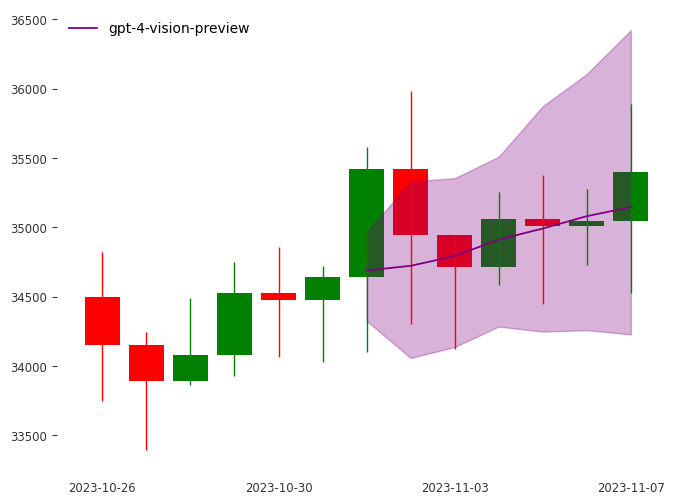

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34805, 35228, 35341, 35805, 36030, 36405, 36569', '34590, 34722, 34666, 34795, 34734, 34860, 34804', '34971, 35176, 35394, 35501, 35920, 36143, 36234', '34610, 34739, 34921, 35138, 35214, 35305, 35411', '34601, 34666, 34626, 34691, 34651, 34716, 34676', '34717, 34768, 34778, 34743, 34720, 34704, 34697', '34562, 34505, 34583, 34534, 34557, 34548, 34553', '34690, 34915, 35019, 35524, 36254, 36811, 37139', '34599, 34672, 34649, 34715, 34679, 34728, 34705', '34722, 34889, 34839, 35004, 35084, 35251, 35201']
serialized list :  [[34805, 35228, 35341, 35805, 36030, 36405, 36569], [34590, 34722, 34666, 34795, 34734, 34860, 34804], [34971, 35176, 35394, 35501, 35920, 36143, 36234], [34610, 34739, 34921, 35138, 35214, 35305, 35411], [34601, 34666, 34626, 34691, 34651, 34716, 34676], [34717, 34768, 34778, 34743, 34720, 34704, 34697], [34562, 34505, 34583, 34534, 34557, 34548, 34553], 

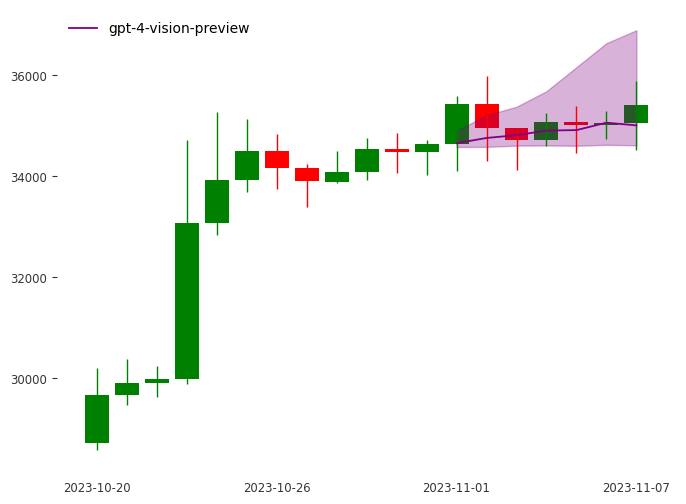

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34677, 34504, 34338, 34072, 34407, 34347, 34271', '35220, 36161, 37206, 38283, 39104, 39956, 40832', '34755, 35037, 35521, 35872, 36314, 36679, 37160', '34592, 34638, 34771, 34905, 35030, 35149, 35256', '34618, 34570, 34522, 34474, 34426, 34378, 34330', '34808, 35681, 36676, 37099, 37020, 37181, 37345', '34718, 34668, 34697, 34736, 34705, 34770, 34739', '34404, 34045, 33740, 33605, 33322, 33041, 32906', '34705, 34922, 34999, 35319, 35498, 35566, 35677', '34678, 34715, 34752, 34789, 34826, 34863, 34900']
serialized list :  [[34677, 34504, 34338, 34072, 34407, 34347, 34271], [35220, 36161, 37206, 38283, 39104, 39956, 40832], [34755, 35037, 35521, 35872, 36314, 36679, 37160], [34592, 34638, 34771, 34905, 35030, 35149, 35256], [34618, 34570, 34522, 34474, 34426, 34378, 34330], [34808, 35681, 366

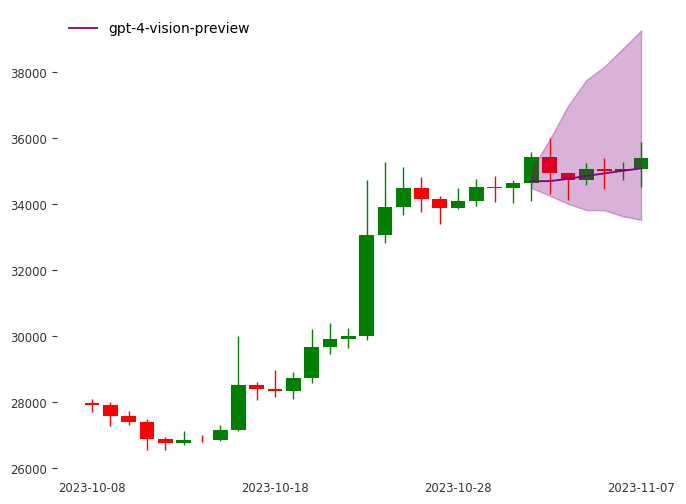

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34682, 34742, 34875, 34912, 34948, 35019, 35057', '34525, 34242, 34006, 33657, 33431, 33221, 33040', '34570, 34579, 34568, 34620, 34715, 34740, 34762', '34804, 34729, 34793, 35231, 35156, 35120, 35043', '34718, 35002, 35113, 35231, 35294, 35421, 35538', '34636, 34621, 34597, 34584, 34572, 34561, 34553', '34796, 34975, 35006, 35000, 34972, 34948, 34931', '34372, 34289, 34226, 34255, 33967, 33884, 33821', '34668, 34905, 34749, 33695, 33508, 33449, 33723', '34605, 34566, 35022, 35232, 35299, 35533, 35672']
serialized list :  [[34682, 34742, 34875, 34912, 34948, 35019, 35057], [34525, 34242, 34006, 33657, 33431, 33221, 33040], [34

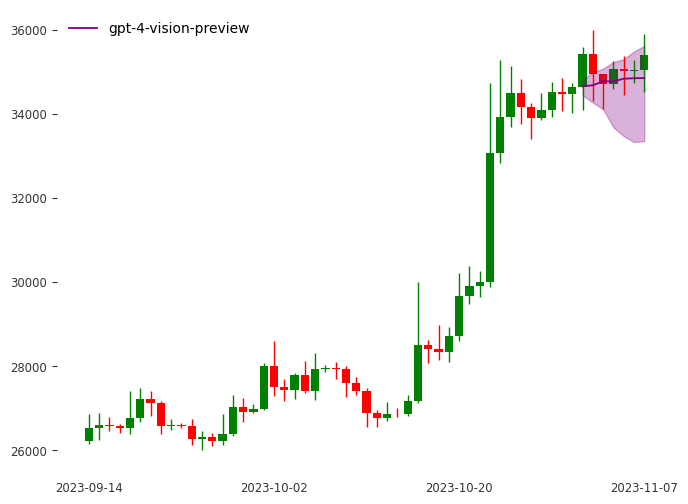

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34632, 34564, 34597, 34540, 34429, 34519, 34520', '34589, 34715, 34670, 34803, 35050, 35110, 35131', '34612, 34518, 34588, 34453, 34531, 34354, 34317', '34607, 34589, 34462, 34406, 34455, 34688, 34719', '34771, 35103, 36358, 36507, 36305, 36852, 37714', '34600, 34559, 34419, 34378, 34237, 34196, 3

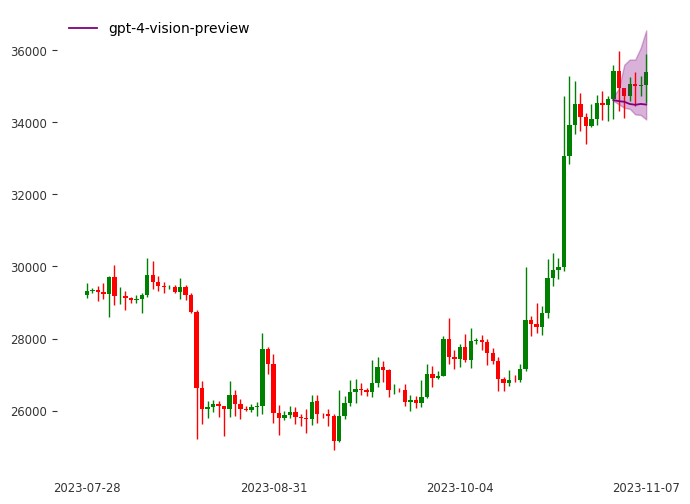

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

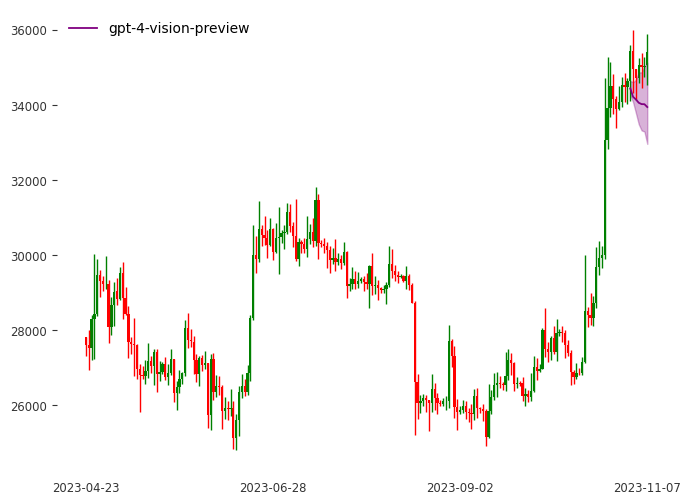

In [2]:
make_prediction(mode = "naive", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [5]:
all_naive_dic = make_dic_MAE_MSE("naive")

{'input_length': {6: {'Mae': [[459.13113246215653, 487.5613064233694, 794.879542611663, 666.9447514835265, 1222.0535351700019, 1457.096726418742, 1409.2234133746533], [1294.1311324621565, 1172.4386935766306, 789.120457388337, 727.0552485164735, 665.9464648299981, 500.90327358125796, 854.7765866253467], [639.1311324621565, 255.4386935766306, 11.879542611663055, 193.0552485164735, 47.94646482999815, 12.096726418742037, 298.7765866253467], [459.13113246215653, 270.5613064233694, 354.87954261166306, 131.0552485164735, 240.05353517000185, 468.09672641874204, 25.77658662534668], [726.1311324621565, 267.4386935766306, 46.879542611663055, 213.0552485164735, 94.94646482999815, 108.90327358125796, 387.7765866253467], [856.1311324621565, 530.4386935766306, 118.12045738833694, 19.05524851647351, 18.94646482999815, 113.09672641874204, 315.7765866253467], [741.1311324621565, 182.4386935766306, 104.87954261166306, 172.0552485164735, 23.94646482999815, 57.09672641874204, 205.77658662534668], [813.1311

In [7]:
display_tab(all_naive_dic)

Global MAE/MSE
  input_length      Mae     Mse
--------------  -------  ------
             6  477.715  338247
            12  395.49   239411
            24  627.428  688259
            48  450.823  294506
            96  486.026  350497
           192  717.297  605787
  input_length      Mae               Mse
--------------  -------  ----------------
             6  423.834  297343
            12  412.756  258336
            24  804.419       1.31874e+06
            48  488.714  404121
            96  543.118  403816
           192  812.818  833068
  input_length      Mae               Mse
--------------  -------  ----------------
             6  446.093  347965
            12  493.048  392880
            24  982.35        2.12042e+06
            48  565      581616
            96  639.922  584688
           192  930.184       1.15752e+06
##############################
Median MAE/MSE
  input_length      Mae     Mse
--------------  -------  ------
             6  342.816  197302
     

Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['89, -83, 131, 136, -42, 142, 190', '100, 29, -190, -19, 330, 110, -485', '172, 123, 353, 231, 628, 433, 1096', '95, 95, 95, 95, 95, 95, 95', '88, 19, -60, -109, 36, -3, -42', '-29, 105, 160, -71, 92, -109, 50', '130, 241, 148, 345, 244, 488, 463', '86, -108, -45, 223, 143, -292, -172', '113, 178, 42, 105, 240, 75, 210', '112, 179, 30, 89, 160, 213, 82']
int list return
[[89, -83, 131, 136, -42, 142, 190], [100, 29, -190, -19, 330, 110, -485], [172, 123, 353, 231, 628, 433, 1096], [95, 95, 95, 95, 95, 95, 95], [88, 19, -60, -109, 36, -3, -42], [-29, 105, 160, -71, 92, -109, 50], [130, 241, 148, 345, 244, 488, 463], [86, -108, -45, 223, 143, -292, -172], [113, 178, 42, 105, 240, 75, 210], [112, 179, 30, 89, 160, 213, 82]]
int list, close
[[34949.04132031571, 34658.96427735709, 35112.99670939047, 35590.53346463818, 35441.0532240867, 35944.316179868736, 36627.258187286236], [34987.14613293574, 35088.60885672125, 34421.92528844355, 

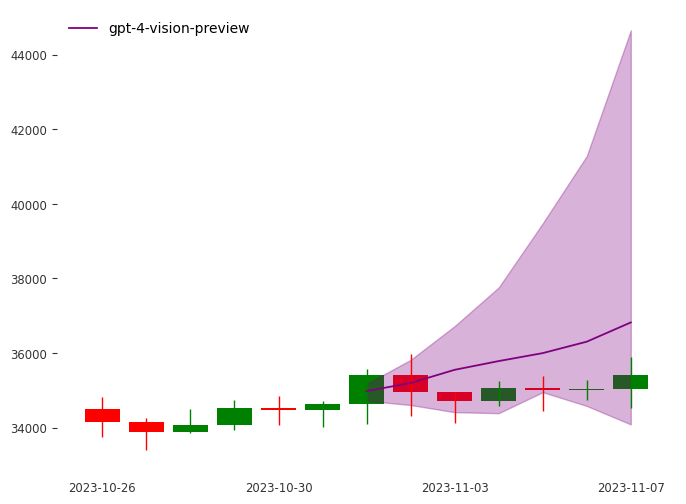

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['3, -23, -166, 207, -308', '-121, -37, 140, 203, -227, -109, 224', '-32, 24, -8, 6, -2, 1, 0', '-59, 33, -43, 28, -27', '-132, 205, -168, 594, 148, 104, -342', '57, -9, -5, 66, 15, 41, -36', '-37, 92, -67, 216, -119', '-25, 29, -39, 24, -55, 21, -73', '-19, 50, -23, 52, -27, 54, -31', '-503, 66, 149, -31, 40, -299, 56']
int list return
[[3, -23, -166, 207, -308, -308, -308], [-121, -37, 140, 203, -227, -109, 224], [-32, 24, -8, 6, -2, 1, 0], [-59, 33, -43, 28, -27, -27, -27], [-132, 205, -168, 594, 148, 104, -342], [57, -9, -5, 66, 15, 41, -36], [-37, 92, -67, 216, -119, -119, -119], [-25, 29, -39, 24, -55, 21, -73], [-19, 50, -23, 52, -27, 54, -31], [-503, 66, 149, -31, 40, -299, 56]]
int list, close
[[34651.130967104575, 34571.433365880235, 33997.547572006624, 34701.29680674716, 33632.49686509935, 32596.615961654286, 31592.640190035334], [34221.58580666061, 34094.96593917596, 34572.29546232443, 352

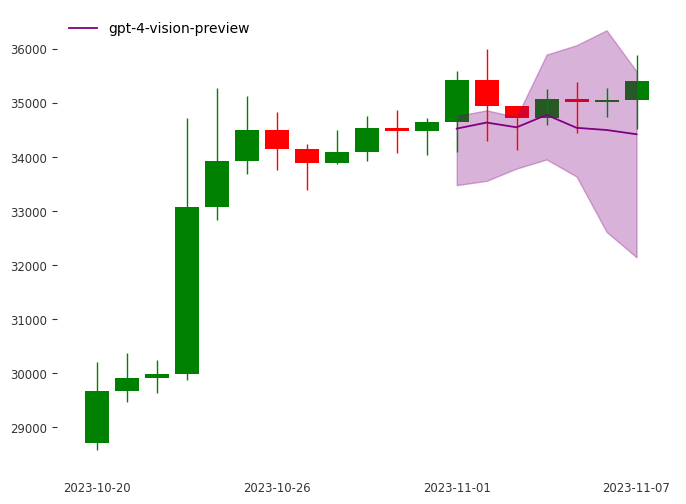

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['235, 422, 606, 809, 1032, 1276, 1541', '75, -203, -175, -50, 25, 175, 546', '217, 212, 207, 202, 197, 192, 187', '93, 150, -19, -7, 181, 263, 109', '71, -103, -7, 159, 276, 194, 268', '225, 304, -144, -243, 369, 1792, 217', '219, 70, -49, -109, -22, 180, 380', '93, -144, 17, -42, 24, 63, -12', '-77, 73, -117, 62, -108, 152, -8', '204, -37, 23, 165, 423, 71, 35']
int list return
[[235, 422, 606, 809, 1032, 1276, 1541], [75, -203, -175, -50, 25, 175, 546], [217, 212, 207, 202, 197, 192, 187], [93, 150, -19, -7, 181, 263, 109], [71, -103, -7, 159, 276, 194, 268], [225, 304, -144, -243, 369, 1792, 217], [219, 70, -49, -109, -22, 180, 380], [93, -144, 17, -42, 24, 63, -12], [-77, 73, -117, 62, -108, 152, -8], [204, -37, 23, 165, 423, 71, 35]]
int list, close
[[35454.79610599973, 36950.988501672924, 39190.2184048743, 42360.70707382863, 46732.3320

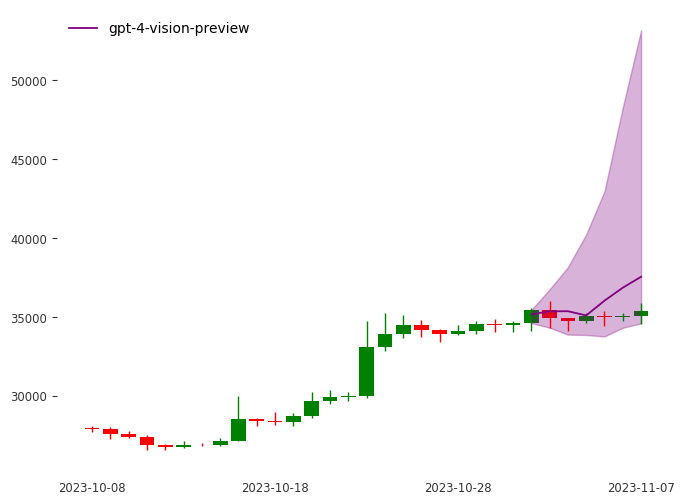

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-8, -60, 87, 70, 202, 52, 27', '-10, -60, -80, 76, 89, -8, 160', '621, -37, -7, 72, 279, 662, 36', '42, -11, -66, 156, 367, 684, 315', '-87, -213, -98, -29, 57, 184, 276', '-98, 202, 197, 84, 205, -25, 243', '-49, -13, 187, 287, 109, -61, 59', '-159, -9, 209, 60, 198, 1091, 326', '272, -49, -191, 172, -47, -24, 54', '-128, -122, -137, -53, 13, 74, 209']
int list return
[[-8, -60, 87, 70, 202, 52, 27], [-10, -60, -80, 76, 89, -8, 160], [621, -37, -7, 72, 279, 662, 36], [42, -11, -66, 156, 367, 684, 315], [-87, -213, -98, -29, 57, 184, 276], [-98, 202, 197, 84, 205, -25, 243], [-49, -13, 187, 287, 109, -61, 59], [-159, -9, 209, 60, 198, 1091, 326], [272, -49, -191, 172, -47, -24, 54], [-128, -122, -137, -53, 13, 74, 209]]
int list

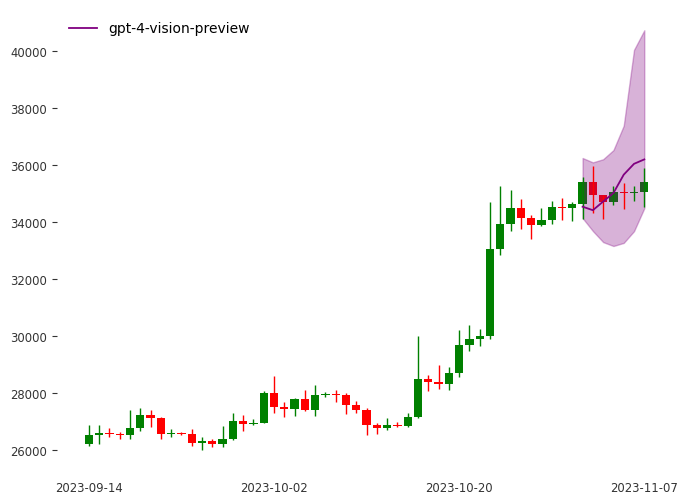

Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-475, -113, 84, 147, -82, -7, 6', '-36, -12, 4, 61, 217, 47, -84', '-453, 102, 152, -71, -58, 36, 99', '-53, -497, -27, 95, 54, 180, -179', '-210, -25, -28, 62, 63, 236, 109', '-193, -176, 75, 49, 43, -29, -78', '-62, -77, 193, -155, -58, 43, -213', '-64, -63, -21, 43, -226, 234, 197', '-10, -3, -22, -45, -717, -172, -25', '365, 205, -778, -84, 60, -18, -117']
int list return
[[-475, -113, 84, 147, -82, -7, 6], [-36, -12, 4, 61, 217, 47, -84], [-453, 102, 152, -71, -58, 36, 99], [-53, -497, -27, 95, 54,

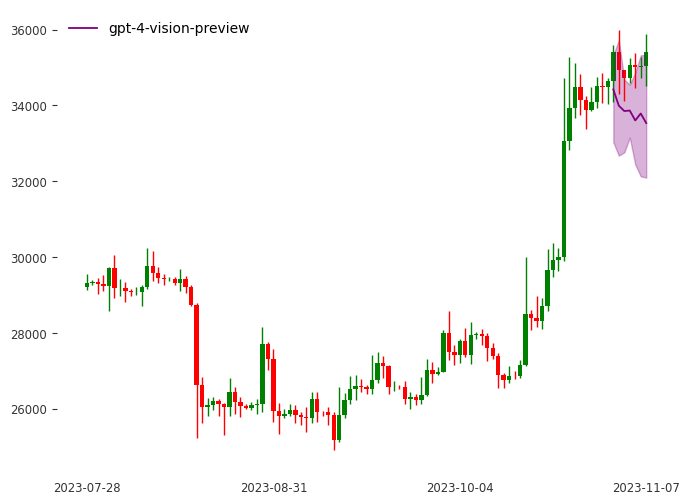

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-69, 153, -118, 19, 33, -16, 189', '-39

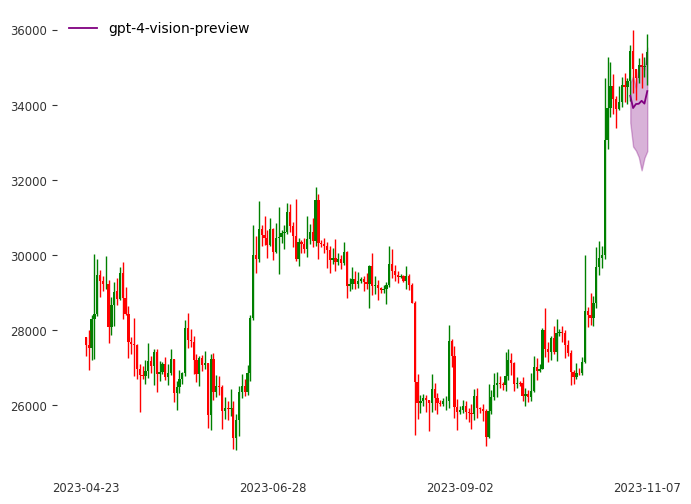

In [2]:
make_prediction(mode = "return", data = "bitcoin_return", setup = None, model = "gpt-4-vision-preview")

In [3]:
all_naive_dic = make_dic_MAE_MSE("return")

dic_error :
{'input_length': {6: {'Mae': [[473.0898121464488, 282.47441621954204, 395.8762520021337, 527.4782161217081, 428.1067592567051, 898.4129062874781, 1227.481600660889], [434.9849995264158, 147.17016314461944, 295.19516894478875, 706.531618120971, 477.3424453685511, 834.7788146294697, 1259.3075796928388], [185.57168055895454, 728.5304395849817, 2211.998586173875, 2719.126444952024, 5141.956238988321, 6847.706717312387, 11085.373059270241], [452.30536889915675, 360.60041474022, 920.2880224575274, 912.9086118879277, 1304.7890522482485, 1616.850730909231, 1611.2735809078076], [476.5538860209999, 70.53514963276393, 84.7815427618043, 640.493980167972, 466.4639759154379, 509.78472941336804, 1008.709740342958], [881.8505293431226, 38.485144124846556, 744.2803488546779, 146.5696120022185, 520.6069444054665, 100.33440349353623, 77.80772116518347], [331.06278328997723, 995.3244028105983, 1751.5067328254227, 2663.739579759662, 3634.3821572560773, 5487.414985262614, 7010.234307602994], [48

In [4]:
display_tab(all_naive_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   592.778  573957
            12   621.548  702353
            24   780.472       1.3743e+06
            48   794.899  910929
            96  1148.89        1.75805e+06
           192  1057.52        1.43695e+06
Mean error with 5 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   893.308       1.71192e+06
            12   625.175  693789
            24  1227.12        5.34466e+06
            48   904.363       1.2527e+06
            96  1215.12        1.90297e+06
           192  1128.56        1.72367e+06
Mean error with 7 days forecasting
  input_length       Mae          Mse
--------------  --------  -----------
             6  1367.81   5.30776e+06
            12   780.996  1.15697e+06
            24  2118.78   2.0406e+07
            48  1237.83   3.15555e+06
       

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U4, D2, U4, U2, U2', 'D2, U2, U4, D2, U2, U4, D2', '"D2", "U2", "U4", "D2", "U4", "U2", "D2"', 'D2, U2, U4, D2, U2, U4, D2', 'D2, U2, U4, D2, U2, U2, U4', 'D2, U2, U4, D2, U2, U4, D2', 'D2, U2, U4, D2, U2, U4, D2', 'D2, U2, U4, D2, U2, U4, D2', 'D2, U2, U4, U4, D2, U4', 'D2, U2, D2, U2, D2, U2, D2']
error :  "D2"
error :   "U2"
error :   "U4"
error :   "D2"
error :   "U4"
error :   "U2"
error :   "D2"
error in seriealization : 
serialized :  [[-1, 1, 3, -1, 3, 1, 1], [-1, 1, 3, -1, 1, 3, -1], [-1, 1, 3, -1, 1, 3, -1], [-1, 1, 3, -1, 1, 1, 3], [-1, 1, 3, -1, 1, 3, -1], [-1, 1, 3, -1, 1, 3, -1], [-1, 1, 3, -1, 1, 3, -1], [-1, 1, 3, 3, -1, 3, 3], [-1, 1, -1, 1, -1, 1, -1]]
int list, close
[[34294, 34636, 35675, 35318, 36377, 36740, 37107], [34294, 34636, 35675, 35318, 35671, 36741, 36373], [34294, 34636, 35675, 35318, 35671, 36741, 36373], [34294, 34636, 35675, 35318, 35671, 36027, 37107], [34294, 34636, 35675

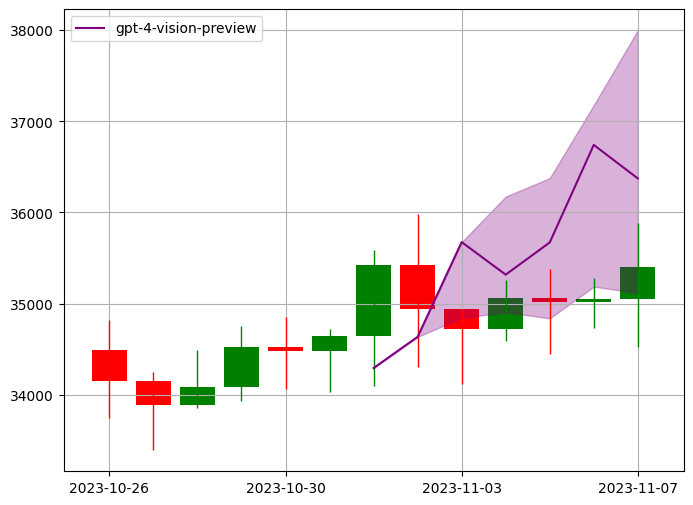

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, D2, U2, U2, U2, U2, U2', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, D4, D6, D6, D8, D10, D10+', 'D2, D4, D2, U2, U2, U2, U4', 'D2, U2, D2, D2, U2, D2, U2', 'U2, D2, U2, D2, U2, D2, U2', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, D2, U2, U2, U2, U2, U2', 'U2, U2, U2, U2, U2, U2, U2', 'D2, D4, D6, D8, D10, D10+, U2']
serialized :  [[-1, -1, 1, 1, 1, 1, 1], [-1, -3, -5, -7, -9, -11, 1], [-1, -3, -5, -5, -7, -9, -11], [-1, -3, -1, 1, 1, 1, 3], [-1, 1, -1, -1, 1, -1, 1], [1, -1, 1, -1, 1, -1, 1], [-1, -3, -5, -7, -9, -11, 1], [-1, -1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [-1, -3, -5, -7, -9, -11, 1]]
int list, close
[[34294, 33951, 34290, 34632, 34978, 35327, 35680], [34294, 33265, 31601, 29388, 26743, 23801, 24039], [34294, 33265, 31601, 30020, 27918, 25405, 22610], [34294, 33265, 32932, 33261, 33593, 33928, 34945], [34294, 34636, 34289, 33946, 34285, 33942, 34281], [34987, 34637, 

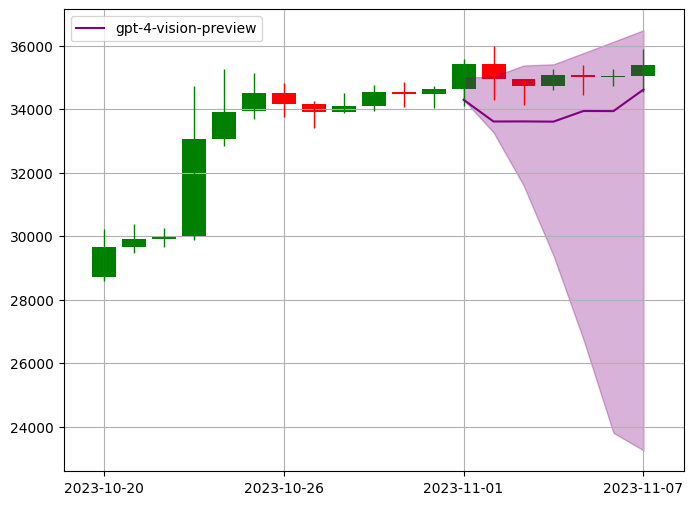

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, U2, U2, U2, U2, U2', 'U2, U2, D2, D4, U2, U2, U4', 'D2, D2, U2, U2, U2, U2, D2', 'U2, U2, U4, U4, U6, U8, U10', 'U2, U2, D2, D2, U2, U2, U2', 'U2, U2, U2, D2, D2, D2, U2', 'D2, D2, D2, D2, D2, D2, D2', 'U2, U2, U2, U2, U2, U2, U2', 'U2, U2, D2, D2, U2, U2, U2', 'U2, U2, U2, U2, U2, U2, U2']
serialized :  [[1, 1, 1, 1, 1, 1, 1], [1, 1, -1, -3, 1, 1, 3], [-1, -1, 1, 1, 1, 1, -1], [1, 1, 3, 3, 5, 7, 9], [1, 1, -1, -1, 1, 1, 1], [1, 1, 1, -1, -1, -1, 1], [-1, -1, -1, -1, -1, -1, -1], [1, 1, 1, 1, 1, 1, 1], [1, 1, -1, -1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]
int list, close
[[34987, 35336, 35689, 36045, 36405, 36769, 37136], [34987, 35336, 34982, 33932, 34271, 34613, 35651], [34294, 33951, 34290, 34632, 34978, 35327, 34973], [34987, 35336, 36396, 37487, 39361, 42116, 45906], [34987, 35336, 34

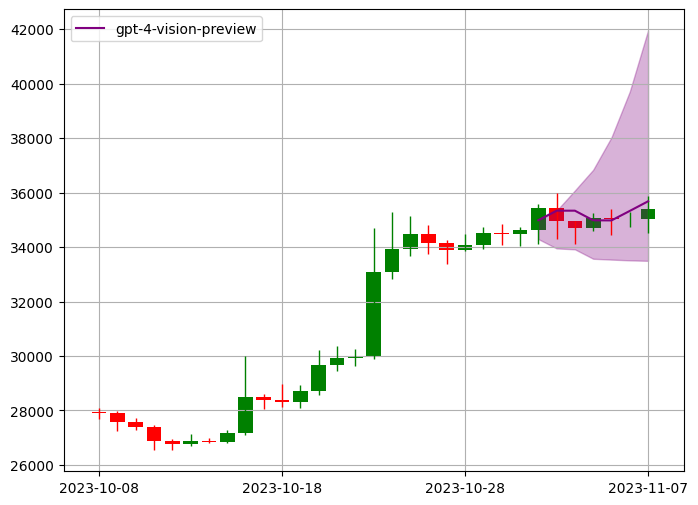

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, D4, D6, D8, D10, D10+, D10+', 'D2, D4, D6, D8, D10, D10+, D10+', 'D2, D4, D6, D8, D10, D10+, U2', 'U4, U2, D2, D4, D4, D6, D8', 'D2, D4, D2, U2, U4, U2, U4', 'D2, D6, D8, D10, D10+, U2, U4', 'D2,D2,D2,U2,U2,U4,U6', 'U2, U2, U4, U4, U6, U8, U10', 'D2, D4, D6, D8, D10, D10+, D10+.', 'U2, U2, D2, U4, U2, U2, U4']
error :   D10+.
serialized :  [[-1, -3, -5, -7, -9, -11, -11], [-1, -3, -5, -7, -9, -11, -11], [-1, -3, -5, -7, -9, -11, 1], [3, 1, -1, -3, -3, -5, -7], [-1, -3, -1, 1, 3, 1, 3], [-1, -5, -7, -9, -11, 1, 3], [-1, -1, -1, 1, 1, 3, 5], [1, 1, 3, 3, 5, 7, 9], [-1, -3, -5, -7, -9, -11, -11], [1, 1, -1, 3, 1, 1, 3]]
int l

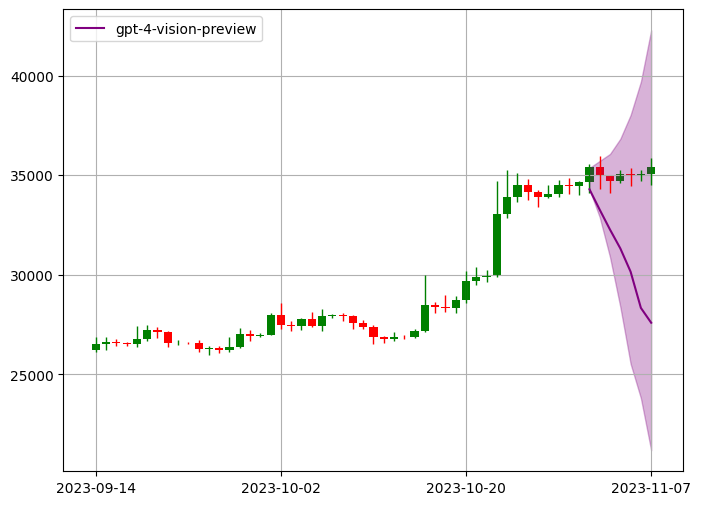

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'U10+,U10+,U10+,U10+,U10+,U10+,U10+', 'U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'D2, D4, D6, D8, D10, D10+, U2', 'U10+, U10+, U10+, U10+, U8, U6, U4.', 'D2, D4, D6, D8, D10, D10+, U2', 'U10+, U10+, U10+, U10+,

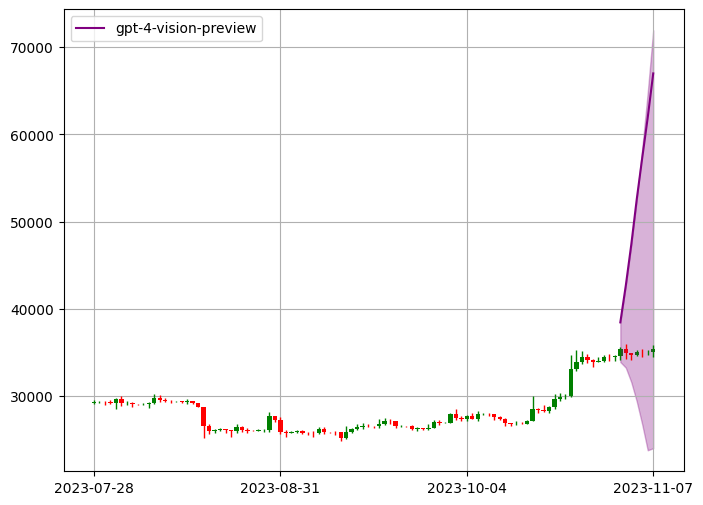

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

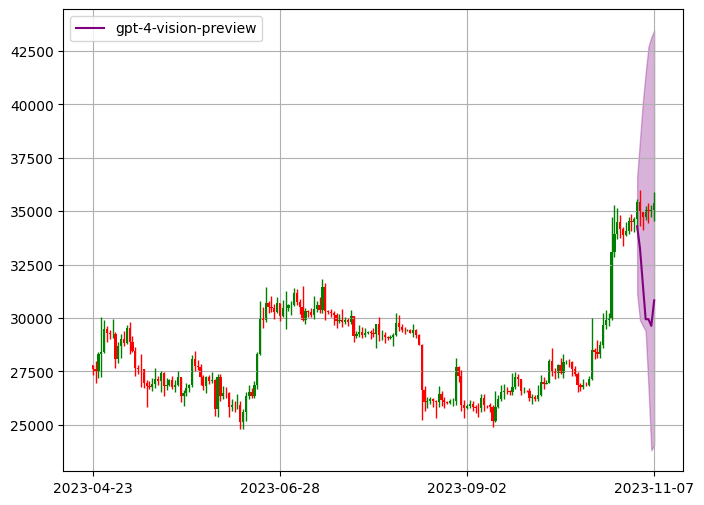

In [13]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "bin/"


dict_error_bin = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

dict_error_bin_median = copy.deepcopy(dict_error_bin)


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt_bin(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = bin_seriealize(list_response)
    print("serialized : ", final_dic_int_list)

    final_dic = convert_bin_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    full_Mae_dict, full_Mse_dict = MAE_MSE_calculator(final_dic, df_raw, input_length)
    dict_error_bin["input_length"][input_length]["Mae"] = full_Mae_dict
    dict_error_bin["input_length"][input_length]["Mse"] = full_Mse_dict


    full_Mae_dict_median, full_Mse_dict_median = MAE_MSE_median_calculator(final_dic, df_raw, input_length)
    dict_error_bin_median["input_length"][input_length]["Mae"] = full_Mae_dict_median
    dict_error_bin_median["input_length"][input_length]["Mse"] = full_Mse_dict_median

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, final_dic, "gpt-4-vision-preview", savefig= current_folder )


with open('pickle/dic_error_bin.pkl', 'wb') as fichier:
    pickle.dump(dict_error_bin, fichier)

with open('pickle/dic_error_bin_median.pkl', 'wb') as fichier:
    pickle.dump(dict_error_bin_median, fichier)



In [15]:
with open('pickle/dic_error_bin.pkl', 'rb') as fichier:
    dict_error_bin = pickle.load(fichier)

with open('pickle/dic_error_bin_median.pkl', 'rb') as fichier:
    dict_error_bin_median = pickle.load(fichier)

dic_error_3_bin = get_basic_dic()
dic_error_5_bin = get_basic_dic()
dic_error_7_bin = get_basic_dic()

dic_error_3_bin_median = get_basic_dic()
dic_error_5_bin_median = get_basic_dic()
dic_error_7_bin_median = get_basic_dic()

print(dict_error_bin)
dic_mgt(dict_error_bin, dic_error_3_bin, dic_error_5_bin, dic_error_7_bin)
dic_mgt(dict_error_bin_median, dic_error_3_bin_median, dic_error_5_bin_median, dic_error_7_bin_median)

print(dic_error_3_bin)


{'input_length': {6: {'Mae': [[1128.1311324621565, 305.4386935766306, 957.879542611663, 254.9447514835265, 1364.0535351700019, 1694.096726418742, 1707.2234133746533], [1128.1311324621565, 305.4386935766306, 957.879542611663, 254.9447514835265, 658.0535351700019, 1695.096726418742, 973.2234133746533], [1128.1311324621565, 305.4386935766306, 957.879542611663, 254.9447514835265, 658.0535351700019, 1695.096726418742, 973.2234133746533], [1128.1311324621565, 305.4386935766306, 957.879542611663, 254.9447514835265, 658.0535351700019, 981.096726418742, 1707.2234133746533], [1128.1311324621565, 305.4386935766306, 957.879542611663, 254.9447514835265, 658.0535351700019, 1695.096726418742, 973.2234133746533], [1128.1311324621565, 305.4386935766306, 957.879542611663, 254.9447514835265, 658.0535351700019, 1695.096726418742, 973.2234133746533], [1128.1311324621565, 305.4386935766306, 957.879542611663, 254.9447514835265, 658.0535351700019, 1695.096726418742, 973.2234133746533], [1128.1311324621565, 30

In [16]:
print("Global MAE/MSE")
table_display(dic_error_3_bin)
table_display(dic_error_5_bin)
table_display(dic_error_7_bin)

print("##############################")
print("Median MAE/MSE")
table_display(dic_error_3_bin_median)
table_display(dic_error_5_bin_median)
table_display(dic_error_7_bin_median)

Global MAE/MSE
  input_length       Mae               Mse
--------------  --------  ----------------
             6   777.529  733974
            12  1267.75        2.35023e+06
            24   625.632  516023
            48  1510.58        3.26863e+06
            96  5293.62        4.706e+07
           192  3015.65        1.34452e+07
  input_length       Mae               Mse
--------------  --------  ----------------
             6   717.717  669750
            12  2016.85        9.17152e+06
            24   801.977       1.17852e+06
            48  2689.83        1.40365e+07
            96  8680.33        1.32783e+08
           192  4012.39        2.52398e+07
  input_length        Mae          Mse
--------------  ---------  -----------
             6    934.659  1.21258e+06
            12   2861.56   2.13175e+07
            24   1099.46   3.62947e+06
            48   4098.59   3.37346e+07
            96  12362.1    2.79047e+08
           192   4913.43   3.94647e+07
#################

Input str :  112, 118, 132, 129, 121, 135, 
GPT Answer :  ['142, 134, 148, 145, 137, 151, 158', '132, 124, 138, 135, 127, 141, 138', '132, 144, 141, 133, 147, 144, 136', '142, 134, 148, 145, 137, 151, 158', '132, 124, 138, 135, 127, 141, 138', '142, 136, 148, 147, 139, 151, 160', '132, 144, 141, 133, 147, 144, 136', '136, 124, 142, 139, 127, 147, 144', '130, 122, 136, 133, 125, 139, 136', '132, 124, 138, 135, 127, 141, 138']
int list APD
[[142, 134, 148, 145, 137, 151, 158], [132, 124, 138, 135, 127, 141, 138], [132, 144, 141, 133, 147, 144, 136], [142, 134, 148, 145, 137, 151, 158], [132, 124, 138, 135, 127, 141, 138], [142, 136, 148, 147, 139, 151, 160], [132, 144, 141, 133, 147, 144, 136], [136, 124, 142, 139, 127, 147, 144], [130, 122, 136, 133, 125, 139, 136], [132, 124, 138, 135, 127, 141, 138]]


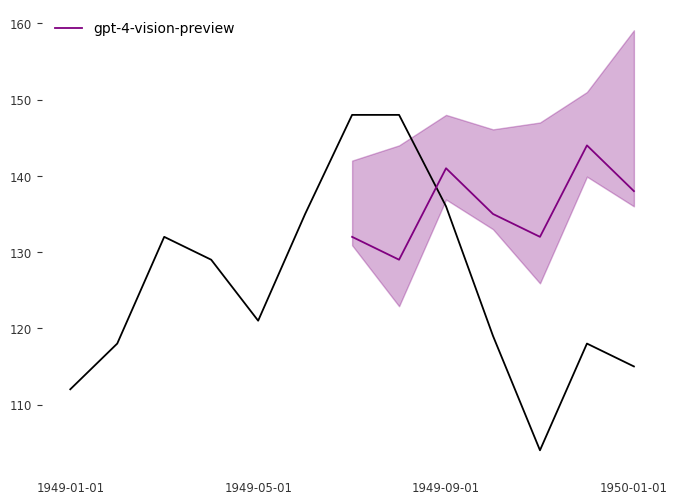

Input str :  112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 
GPT Answer :  ['139, 133, 126, 141, 154, 155, 142', '131, 143, 138, 126, 141, 155, 154', '117, 136, 148, 143, 121, 106, 121', '131, 126, 120, 134, 147, 147, 135', '132, 157, 176, 180, 168, 151, 136', '141, 138, 130, 144, 157, 157, 145', '131, 130, 126, 138, 153, 155, 145', '123, 121, 118, 114, 119, 133, 140', '132, 129, 121, 135, 148, 148, 136', '135, 156, 164, 158, 133, 116, 116']
int list APD
[[139, 133, 126, 141, 154, 155, 142], [131, 143, 138, 126, 141, 155, 154], [117, 136, 148, 143, 121, 106, 121], [131, 126, 120, 134, 147, 147, 135], [132, 157, 176, 180, 168, 151, 136], [141, 138, 130, 144, 157, 157, 145], [131, 130, 126, 138, 153, 155, 145], [123, 121, 118, 114, 119, 133, 140], [132, 129, 121, 135, 148, 148, 136], [135, 156, 164, 158, 133, 116, 116]]


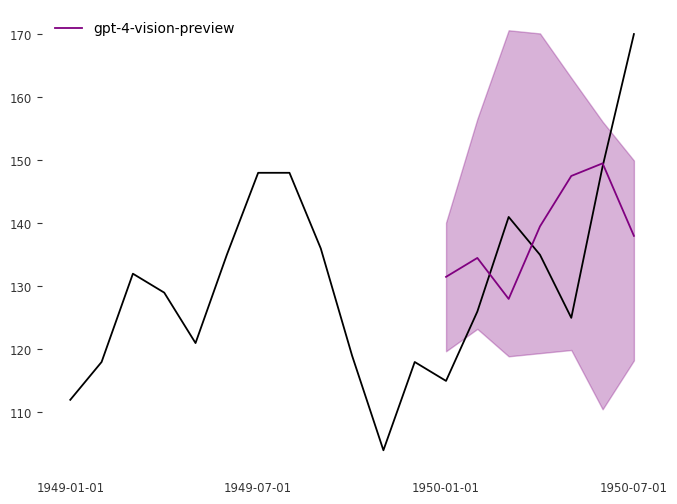

Input str :  112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 


APIError: The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.) {
  "error": {
    "message": "The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.)",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.)', 'type': 'server_error', 'param': None, 'code': None}} <CIMultiDictProxy('Server': 'gunicorn', 'Date': 'Tue, 02 Apr 2024 00:22:39 GMT', 'Connection': 'keep-alive', 'Content-Type': 'application/json', 'Content-Length': '370', 'Access-Control-Allow-Origin': '*', 'OpenAI-Version': '2020-11-07', 'OpenAI-Organization': 'prendinger-lab', 'X-Request-ID': 'req_34920c6a0e8779fdada2e42b7cc954b7', 'OpenAI-Processing-Ms': '217')> {
  "error": {
    "message": "The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.) {\n  \"error\": {\n    \"message\": \"The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.)\",\n    \"type\": \"server_error\",\n    \"param\": null,\n    \"code\": null\n  }\n}\n 500 {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.)', 'type': 'server_error', 'param': None, 'code': None}} <CIMultiDictProxy('Server': 'gunicorn', 'Date': 'Tue, 02 Apr 2024 00:22:39 GMT', 'Connection': 'keep-alive', 'Content-Type': 'application/json', 'Content-Length': '370', 'Access-Control-Allow-Origin': '*', 'OpenAI-Version': '2020-11-07', 'OpenAI-Organization': 'prendinger-lab', 'X-Request-ID': 'req_34920c6a0e8779fdada2e42b7cc954b7', 'OpenAI-Processing-Ms': '217')>",
    "type": null,
    "param": null,
    "code": null
  }
} 500 {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.) {\n  "error": {\n    "message": "The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.)",\n    "type": "server_error",\n    "param": null,\n    "code": null\n  }\n}\n 500 {\'error\': {\'message\': \'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_34920c6a0e8779fdada2e42b7cc954b7 in your email.)\', \'type\': \'server_error\', \'param\': None, \'code\': None}} <CIMultiDictProxy(\'Server\': \'gunicorn\', \'Date\': \'Tue, 02 Apr 2024 00:22:39 GMT\', \'Connection\': \'keep-alive\', \'Content-Type\': \'application/json\', \'Content-Length\': \'370\', \'Access-Control-Allow-Origin\': \'*\', \'OpenAI-Version\': \'2020-11-07\', \'OpenAI-Organization\': \'prendinger-lab\', \'X-Request-ID\': \'req_34920c6a0e8779fdada2e42b7cc954b7\', \'OpenAI-Processing-Ms\': \'217\')>', 'type': None, 'param': None, 'code': None}} {'Date': 'Tue, 02 Apr 2024 00:22:39 GMT', 'Content-Type': 'application/json', 'Content-Length': '1469', 'Connection': 'keep-alive', 'openai-organization': 'prendinger-lab', 'openai-processing-ms': '804', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '1000', 'x-ratelimit-limit-tokens': '20000', 'x-ratelimit-remaining-requests': '989', 'x-ratelimit-remaining-tokens': '19708', 'x-ratelimit-reset-requests': '15m18.868s', 'x-ratelimit-reset-tokens': '876ms', 'x-request-id': 'req_34920c6a0e8779fdada2e42b7cc954b7', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '86dcaa69090f8a4b-NRT', 'alt-svc': 'h3=":443"; ma=86400'}

In [11]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "APD/"

dict_error_APD = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

dict_error_APD_median = copy.deepcopy(dict_error_APD)

for input_length in [6, 12, 24, 48, 96, 192] :

    df_raw, train, test = get_data_darts(input_length)   
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic = basic_seriealize(list_response)
    print("int list APD")
    print(final_dic)

    full_Mae_dict, full_Mse_dict = MAE_MSE_calculator(final_dic, df_raw, input_length)
    dict_error_APD["input_length"][input_length]["Mae"] = full_Mae_dict.copy()
    dict_error_APD["input_length"][input_length]["Mse"] = full_Mse_dict.copy()

    full_Mae_dict_median, full_Mse_dict_median = MAE_MSE_median_calculator(final_dic, df_raw, input_length)
    dict_error_APD_median["input_length"][input_length]["Mae"] = full_Mae_dict_median.copy()
    dict_error_APD_median["input_length"][input_length]["Mse"] = full_Mse_dict_median.copy()

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_pred_classic(df_raw, train, final_dic, "gpt-4-vision-preview",  savefig = current_folder)


with open('pickle/dic_error_APD.pkl', 'wb') as fichier:
    pickle.dump(dict_error_APD, fichier)

with open('pickle/dic_error_APD_median.pkl', 'wb') as fichier:
    pickle.dump(dict_error_APD_median, fichier)




In [2]:
with open('pickle/dic_error_APD.pkl', 'rb') as fichier:
    dict_error_APD = pickle.load(fichier)

with open('pickle/dic_error_APD_median.pkl', 'rb') as fichier:
    dict_error_APD_median = pickle.load(fichier)

dic_error_3_APD = get_basic_dic()
dic_error_5_APD = get_basic_dic()
dic_error_7_APD = get_basic_dic()

dic_error_3_APD_median = get_basic_dic()
dic_error_5_APD_median = get_basic_dic()
dic_error_7_APD_median = get_basic_dic()

print(dict_error_APD)
dic_mgt(dict_error_APD, dic_error_3_APD, dic_error_5_APD, dic_error_7_APD)
dic_mgt(dict_error_APD_median, dic_error_3_APD_median, dic_error_5_APD_median, dic_error_7_APD_median)

print(dic_error_3_APD)

{'input_length': {6: {'Mae': [[5, 14, 16, 34, 41, 39, 48], [12, 21, 23, 41, 48, 46, 55], [5, 14, 16, 34, 41, 39, 48], [5, 14, 16, 34, 41, 39, 48], [5, 14, 16, 34, 41, 39, 48], [5, 14, 16, 34, 41, 39, 48], [5, 14, 16, 34, 41, 39, 48], [5, 14, 16, 34, 41, 39, 48], [4, 7, 5, 22, 103, 328, 884], [16, 7, 16, 34, 41, 39, 49]], 'Mse': [[25, 196, 256, 1156, 1681, 1521, 2304], [144, 441, 529, 1681, 2304, 2116, 3025], [25, 196, 256, 1156, 1681, 1521, 2304], [25, 196, 256, 1156, 1681, 1521, 2304], [25, 196, 256, 1156, 1681, 1521, 2304], [25, 196, 256, 1156, 1681, 1521, 2304], [25, 196, 256, 1156, 1681, 1521, 2304], [25, 196, 256, 1156, 1681, 1521, 2304], [16, 49, 25, 484, 10609, 107584, 781456], [256, 49, 256, 1156, 1681, 1521, 2401]]}, 12: {'Mae': [[25, 37, 45, 49, 43, 31, 15], [14, 33, 56, 83, 108, 131, 152], [19, 45, 55, 60, 58, 53, 42], [27, 55, 60, 62, 60, 55, 49], [16, 41, 62, 67, 65, 60, 48], [1, 49, 26, 22, 41, 50, 53], [5, 17, 15, 10, 7, 10, 21], [11, 9, 3, 13, 16, 24, 44], [12, 5, 8, 20

In [5]:
print("Global MAE/MSE")
table_display(dic_error_3_APD)
table_display(dic_error_5_APD)
table_display(dic_error_7_APD)

print("##############################")
print("Median MAE/MSE")
table_display(dic_error_3_APD_median)
table_display(dic_error_5_APD_median)
table_display(dic_error_7_APD_median)

Global MAE/MSE
  input_length       Mae        Mse
--------------  --------  ---------
             6  11.8667    170.133
            12  26.4667   1065.13
            24   9.1       109.833
            48  10.3667    145.3
            96   2.73333    13.0667
           192  22.3       575.433
  input_length    Mae      Mse
--------------  -----  -------
             6  23.4    857.56
            12  32.66  1647.34
            24  12.5    228.34
            48  12.86   235.82
            96   4.54    34.82
           192  19.36   454.2
  input_length       Mae        Mse
--------------  --------  ---------
             6  45.4286   13825.1
            12  37.7857    2303.61
            24  14.7        366.443
            48  17.9143     520.886
            96   6.34286     74.6
           192  16.8857     376.314
##############################
Median MAE/MSE
  input_length       Mae        Mse
--------------  --------  ---------
             6  11.6667   159
            12  22.6667   5